<a href="https://colab.research.google.com/github/rkgupta7463/ML-projects-code/blob/main/Human_Face_Exp(ResNet50_%26_VGG19%2C16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d sanidhyak/human-face-emotions

human-face-emotions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
import zipfile
zip = zipfile.ZipFile("/content/human-face-emotions.zip",'r')
zip.extractall("/content")
zip.close()

In [94]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import image_dataset_from_directory

In [138]:
from tensorflow.keras.applications import Xception,VGG19,VGG16
from tensorflow.keras.layers import Input, Flatten, Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [96]:
# Define paths to your training and validation data directories
data_dir = "/content/data"

# Create data generator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # Specify the validation split here
)

batch_size = 32
input_shape = (224, 224, 3)

# Load training data from the subdirectories and apply data augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="training"  # Specify the subset as "training"
)

# Load validation data from the same subdirectories (without data augmentation)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # No need to shuffle validation data
    seed=42,
    subset="validation"  # Specify the subset as "validation"
)

Found 212 images belonging to 3 classes.
Found 52 images belonging to 3 classes.


In [97]:
# Load pretrained Xception model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling=None
)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
flatten = Flatten()(base_model.output)
dense1 = Dense(512, activation="relu")(flatten)
output_layer = Dense(train_generator.num_classes, activation="softmax")(dense1)

# Create the Xception model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [98]:
# Train the model
epochs = 10
history=model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/10
7/7 [==============================] - 14s 1s/step - loss: 31.8156 - accuracy: 0.4292 - val_loss: 11.3400 - val_accuracy: 0.4808
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 4.6390 - accuracy: 0.6462 - val_loss: 5.0158 - val_accuracy: 0.4231
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 2.8828 - accuracy: 0.7075 - val_loss: 5.8320 - val_accuracy: 0.4423
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 2.1775 - accuracy: 0.6887 - val_loss: 5.0050 - val_accuracy: 0.5769
Epoch 5/10
7/7 [==============================] - 9s 1s/step - loss: 1.1201 - accuracy: 0.7972 - val_loss: 3.8857 - val_accuracy: 0.5000
Epoch 6/10
7/7 [==============================] - 9s 1s/step - loss: 0.6351 - accuracy: 0.8349 - val_loss: 3.8418 - val_accuracy: 0.6731
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.5740 - accuracy: 0.8821 - val_loss: 3.8695 - val_accuracy: 0.5192
Epoch 8/10
7/7 [=====================

In [99]:
threshold=0.5
# Get true labels for validation data
val_true_labels = val_generator.classes
# Get predictions from the model
y_pred_xcp = model.predict(val_generator)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred_xcp, axis=1)

2/2 [==============================] - 2s 819ms/step


In [100]:
##importing the evaluation metrics
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix,classification_report

In [131]:
# Calculate accuracy
accuracy = accuracy_score(val_true_labels, y_pred_labels)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

Validation Accuracy: 61.54%


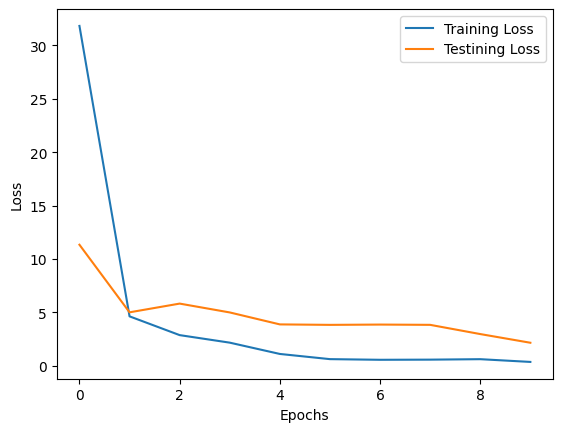

In [102]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Testining Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

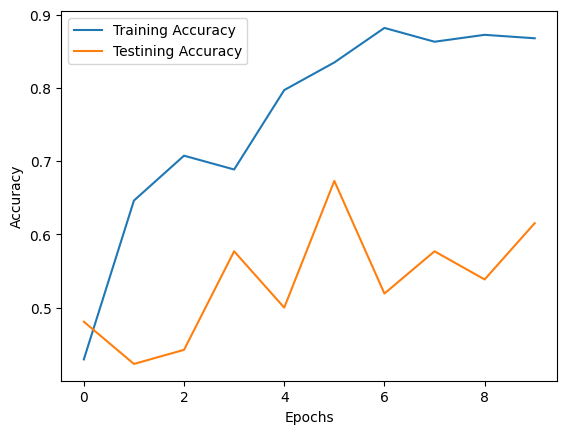

In [103]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Testining Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

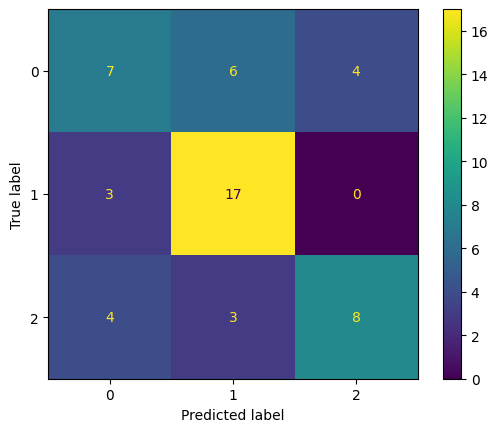

In [104]:
ConfusionMatrixDisplay(confusion_matrix(val_true_labels, y_pred_labels)).plot()

In [105]:
import cv2 as cv
import matplotlib.pyplot as plt
from keras.utils import img_to_array,array_to_img

In [106]:
img=cv.imread('face-smiling.webp')

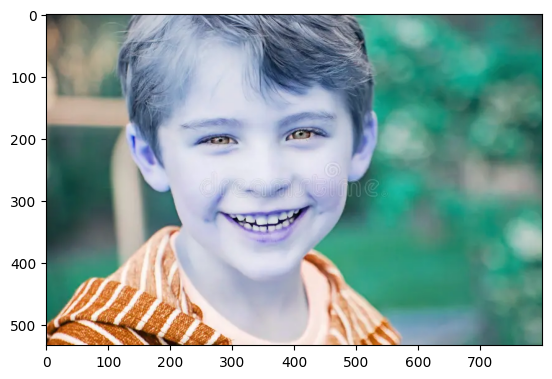

In [107]:
plt.imshow(img)

In [108]:
sample_img = img_to_array(img)

# Resize the image to match the model's input shape (224, 224)
sample_img = cv.resize(sample_img, (224, 224))

# Normalize the pixel values to the range [0, 1]
sample_img = sample_img.astype(np.float32) / 255.0

# Reshape the image to a single-sample batch with the appropriate shape
sample_img = np.expand_dims(sample_img, axis=0)

# Now you can use the model to predict on the sample_img
predictions = model.predict(sample_img)
predictions

print("Predictions:", predictions)

1/1 [==============================] - 1s 742ms/step
Predictions: [[0.86890286 0.03597187 0.09512525]]


In [114]:
s={'Happy':predictions[0][1]*100,
   'Sad':predictions[0][2]*100,
   'Angery':predictions[0][0]*100}

In [115]:
pd.DataFrame([s],index=["Unknow Boy"])

,Happy,Sad,Angery
Unknow Boy,3.597187,9.512525,86.890286


In [113]:
# Load pretrained Xception model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling=None
)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
flatten = Flatten()(base_model.output)
dense1 = Dense(512, activation="relu")(flatten)
dropout1=Dropout(0.9)(dense1)

dense2 = Dense(512, activation="relu")(dense1)
dropout2 = Dropout(0.9)(dense2)

output_layer = Dense(train_generator.num_classes, activation="softmax")(dense2)

# Create the Xception model
model1 = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [116]:
# Train the model
epochs = 10
history1=model1.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/10
7/7 [==============================] - 14s 2s/step - loss: 22.4972 - accuracy: 0.3679 - val_loss: 12.4379 - val_accuracy: 0.3269
Epoch 2/10
7/7 [==============================] - 9s 1s/step - loss: 6.0477 - accuracy: 0.4906 - val_loss: 4.7524 - val_accuracy: 0.3846
Epoch 3/10
7/7 [==============================] - 13s 2s/step - loss: 1.4098 - accuracy: 0.6934 - val_loss: 2.6861 - val_accuracy: 0.5192
Epoch 4/10
7/7 [==============================] - 9s 1s/step - loss: 0.8746 - accuracy: 0.7972 - val_loss: 2.5211 - val_accuracy: 0.6346
Epoch 5/10
7/7 [==============================] - 10s 2s/step - loss: 0.8848 - accuracy: 0.7594 - val_loss: 1.3879 - val_accuracy: 0.5962
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.6667 - accuracy: 0.8160 - val_loss: 2.3196 - val_accuracy: 0.5192
Epoch 7/10
7/7 [==============================] - 13s 2s/step - loss: 0.6105 - accuracy: 0.8255 - val_loss: 1.6129 - val_accuracy: 0.5962
Epoch 8/10
7/7 [==================

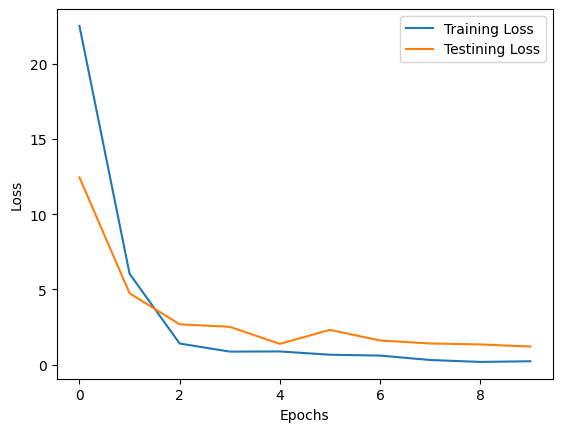

In [117]:
plt.plot(history1.history['loss'],label='Training Loss')
plt.plot(history1.history['val_loss'],label='Testining Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

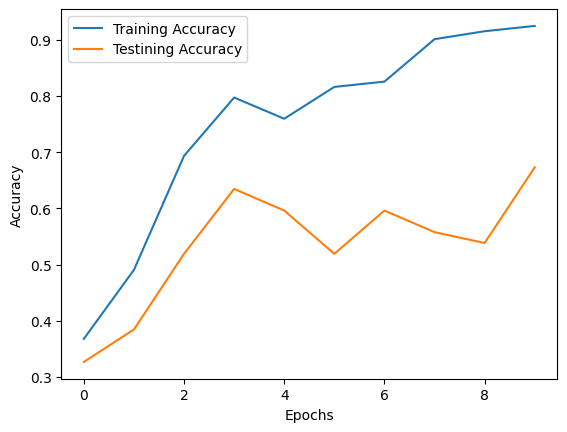

In [118]:
plt.plot(history1.history['accuracy'],label='Training Accuracy')
plt.plot(history1.history['val_accuracy'],label='Testining Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [119]:
threshold=0.5
# Get true labels for validation data
val_true_labels1 = val_generator.classes
# Get predictions from the model
y_pred_xcp1 = model1.predict(val_generator)

# Convert predicted probabilities to class labels
y_pred_labels1 = np.argmax(y_pred_xcp1, axis=1)
# Calculate accuracy
accuracy = accuracy_score(val_true_labels1, y_pred_labels1)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

2/2 [==============================] - 3s 1s/step
Validation Accuracy: 69.23%


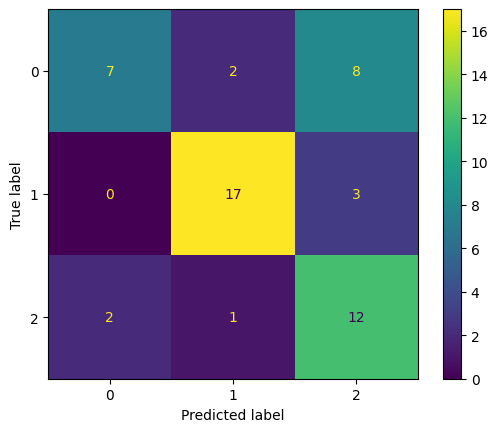

In [120]:
ConfusionMatrixDisplay(confusion_matrix(val_true_labels1, y_pred_labels1)).plot()

In [121]:
sample_img = img_to_array(img)

# Resize the image to match the model's input shape (224, 224)
sample_img = cv.resize(sample_img, (224, 224))

# Normalize the pixel values to the range [0, 1]
sample_img = sample_img.astype(np.float32) / 255.0

# Reshape the image to a single-sample batch with the appropriate shape
sample_img = np.expand_dims(sample_img, axis=0)

# Now you can use the model to predict on the sample_img
predictions1 = model1.predict(sample_img)
predictions1

print("Predictions:", predictions1)

1/1 [==============================] - 1s 692ms/step
Predictions: [[0.05244923 0.8473175  0.1002332 ]]


In [122]:
s={'Angery':predictions1[0][0]*100,
    'Happy':predictions1[0][1]*100,
   'Sad':predictions1[0][2]*100}
pd.DataFrame([s],index=['Unknow boy'])

,Angery,Happy,Sad
Unknow boy,5.244923,84.731752,10.02332


In [123]:
from tensorflow.keras.callbacks import LearningRateScheduler
# Define a learning rate schedule
def learning_rate_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.5

# Set up callbacks
lr_scheduler = LearningRateScheduler(learning_rate_schedule)


# Load pretrained Xception model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling=None
)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
flatten = Flatten()(base_model.output)
dense1 = Dense(512, activation="relu")(flatten)
dropout1=Dropout(0.9)(dense1)

dense2 = Dense(512, activation="relu")(dense1)
dropout2 = Dropout(0.9)(dense2)

dense3 = Dense(512, activation="relu")(dense2)
dropout3 = Dropout(0.9)(dense3)

output_layer = Dense(train_generator.num_classes, activation="softmax")(dense3)

# Create the Xception model
model2 = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model2.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [124]:
# Train the model with data augmentation and learning rate scheduling
history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_scheduler]
)

Epoch 1/20
7/7 [==============================] - 14s 1s/step - loss: 13.3156 - accuracy: 0.3585 - val_loss: 6.4407 - val_accuracy: 0.3462 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 9s 1s/step - loss: 3.8351 - accuracy: 0.4811 - val_loss: 2.6915 - val_accuracy: 0.3654 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 1.8071 - accuracy: 0.5943 - val_loss: 1.9260 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 1.1149 - accuracy: 0.6981 - val_loss: 1.6110 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 9s 1s/step - loss: 0.6858 - accuracy: 0.7736 - val_loss: 1.5071 - val_accuracy: 0.5577 - lr: 0.0010
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 0.5263 - accuracy: 0.8349 - val_loss: 1.1881 - val_accuracy: 0.6346 - lr: 5.0000e-04
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.3441 - accuracy: 0.8774

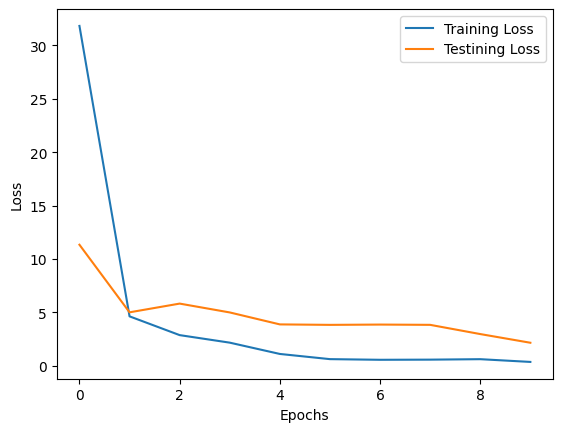

In [125]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Testining Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

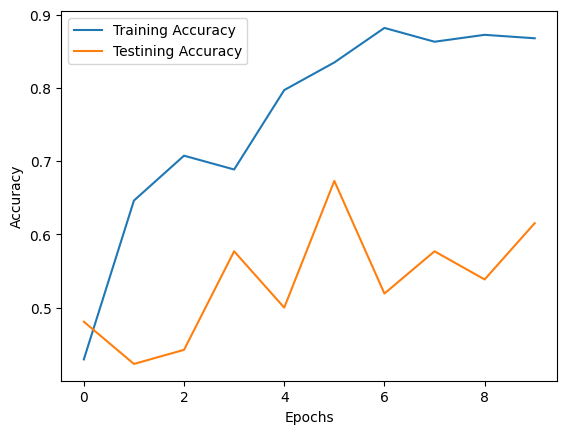

In [126]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Testining Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [127]:
threshold=0.5
# Get true labels for validation data
val_true_labels2 = val_generator.classes
# Get predictions from the model
y_pred_xcp2 = model2.predict(val_generator)

# Convert predicted probabilities to class labels
y_pred_labels2 = np.argmax(y_pred_xcp2, axis=1)
# Calculate accuracy
accuracy = accuracy_score(val_true_labels2, y_pred_labels2)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

2/2 [==============================] - 3s 792ms/step
Validation Accuracy: 55.77%


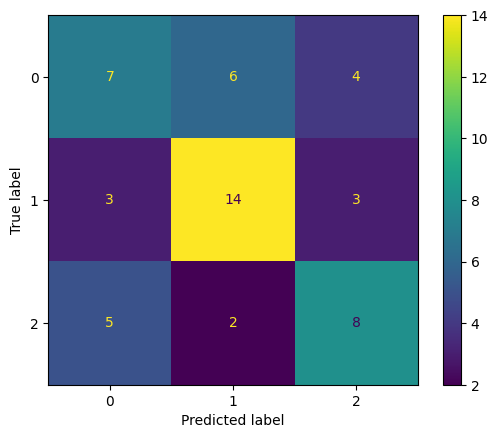

In [128]:
ConfusionMatrixDisplay(confusion_matrix(val_true_labels2, y_pred_labels2)).plot()

In [129]:
sample_img = img_to_array(img)

# Resize the image to match the model's input shape (224, 224)
sample_img = cv.resize(sample_img, (224, 224))

# Normalize the pixel values to the range [0, 1]
sample_img = sample_img.astype(np.float32) / 255.0

# Reshape the image to a single-sample batch with the appropriate shape
sample_img = np.expand_dims(sample_img, axis=0)

# Now you can use the model to predict on the sample_img
predictions2 = model2.predict(sample_img)
predictions2

print("Predictions:", predictions2)

1/1 [==============================] - 1s 733ms/step
Predictions: [[0.16256689 0.75838506 0.07904807]]


In [130]:
s={'Angery':predictions2[0][0]*100,
   'Happy':predictions2[0][1]*100,
   'Sad':predictions2[0][2]*100}
pd.DataFrame([s],index=['Unknow boy'])

,Angery,Happy,Sad
Unknow boy,16.256689,75.838506,7.904807


In [135]:
pd.DataFrame([[accuracy_score(val_true_labels2, y_pred_labels2),accuracy_score(val_true_labels1, y_pred_labels1),accuracy_score(val_true_labels, y_pred_labels)]],columns=['Model-3','Model-2','Model-1'])

,Model-3,Model-2,Model-1
0,0.557692,0.692308,0.615385


In [136]:
print("As We can see over here our second model is well performing on this problem")

As We can see over here our second model is well performing on this problem


In [137]:
model2.save("Xcep_CV_Model.h5")

In [141]:
model1.save("Xcep_CV_Model_1.h5")

### **Now Let's Try with VGG19 or VGG16**

In [139]:
# Load pretrained VGG16 model
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling=None
)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
flatten = Flatten()(base_model.output)
dense1 = Dense(512, activation="relu")(flatten)
dropout1 = Dropout(0.5)(dense1)

dense2 = Dense(512, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(dense2)

output_layer = Dense(train_generator.num_classes, activation="softmax")(dropout2)

# Create the VGG16 model
vgg_model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
vgg_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
vgg_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [140]:
# Train the model with data augmentation and learning rate scheduling
history_vg = vgg_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_scheduler]
)

Epoch 1/20
7/7 [==============================] - 18s 2s/step - loss: 3.3433 - accuracy: 0.3726 - val_loss: 0.9767 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 3.0795 - accuracy: 0.3726 - val_loss: 1.0179 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 9s 1s/step - loss: 2.8115 - accuracy: 0.4481 - val_loss: 1.5122 - val_accuracy: 0.4231 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 1.9806 - accuracy: 0.4104 - val_loss: 1.2541 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 1.2899 - accuracy: 0.5000 - val_loss: 0.9527 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 1.0528 - accuracy: 0.5330 - val_loss: 0.8494 - val_accuracy: 0.5962 - lr: 5.0000e-04
Epoch 7/20
7/7 [==============================] - 9s 1s/step - loss: 0.8243 - accuracy: 0.5991 

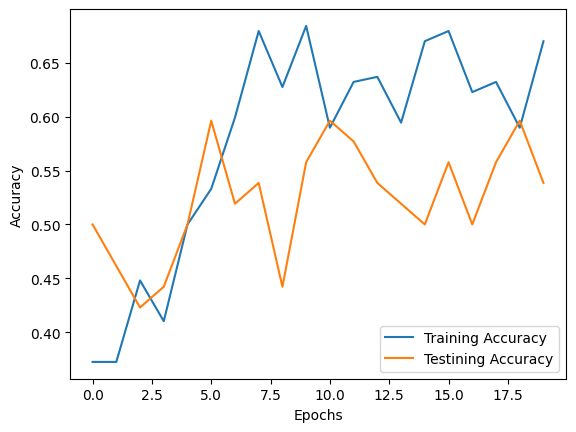

In [142]:
plt.plot(history_vg.history['accuracy'],label='Training Accuracy')
plt.plot(history_vg.history['val_accuracy'],label='Testining Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

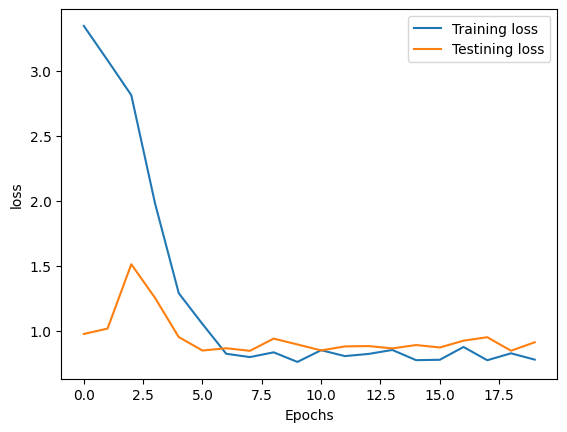

In [143]:
plt.plot(history_vg.history['loss'],label='Training loss')
plt.plot(history_vg.history['val_loss'],label='Testining loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

In [148]:
threshold=0.5
# Get true labels for validation data
val_true_labels3 = val_generator.classes
# Get predictions from the model
y_pred_xcp3 = vgg_model.predict(val_generator)

# Convert predicted probabilities to class labels
y_pred_labels3 = np.argmax(y_pred_xcp2, axis=1)
# Calculate accuracy
accuracy3 = accuracy_score(val_true_labels3, y_pred_labels3)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

2/2 [==============================] - 2s 798ms/step
Validation Accuracy: 63.46%


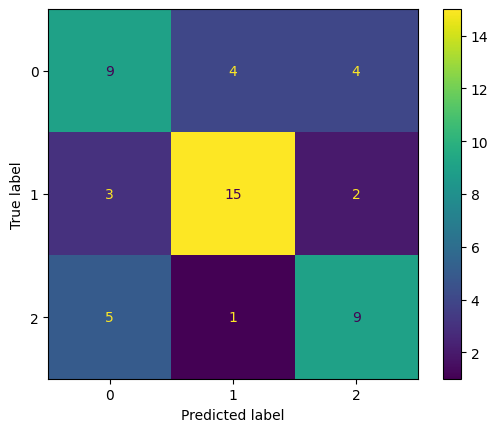

In [149]:
ConfusionMatrixDisplay(confusion_matrix(val_true_labels3, y_pred_labels3)).plot()

In [150]:
sample_img = img_to_array(img)

# Resize the image to match the model's input shape (224, 224)
sample_img = cv.resize(sample_img, (224, 224))

# Normalize the pixel values to the range [0, 1]
sample_img = sample_img.astype(np.float32) / 255.0

# Reshape the image to a single-sample batch with the appropriate shape
sample_img = np.expand_dims(sample_img, axis=0)

# Now you can use the model to predict on the sample_img
predictions3 = vgg_model.predict(sample_img)
predictions3

print("Predictions:", predictions3)

1/1 [==============================] - 1s 815ms/step
Predictions: [[0.51721364 0.35228947 0.13049695]]


In [151]:
s={'Angery':predictions3[0][0]*100,
   'Happy':predictions3[0][1]*100,
   'Sad':predictions3[0][2]*100}
pd.DataFrame([s],index=['Unknow boy'])

,Angery,Happy,Sad
Unknow boy,51.721364,35.228947,13.049695


In [154]:
##now let's try with vgg19
# Load pretrained VGG19 model
base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling=None
)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
flatten = Flatten()(base_model.output)
dense1 = Dense(512, activation="relu")(flatten)
dropout1 = Dropout(0.5)(dense1)

dense2 = Dense(512, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(dense2)

output_layer = Dense(train_generator.num_classes, activation="softmax")(dropout2)

# Create the VGG19 model
model_vgg19 = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model_vgg19.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model_vgg19.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [155]:
# Train the model with data augmentation and learning rate scheduling
history_vgg19 = model_vgg19.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_scheduler]
)

Epoch 1/20
7/7 [==============================] - 12s 1s/step - loss: 4.8036 - accuracy: 0.2972 - val_loss: 2.1483 - val_accuracy: 0.4038 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 9s 1s/step - loss: 3.7508 - accuracy: 0.3868 - val_loss: 1.5787 - val_accuracy: 0.4808 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 9s 1s/step - loss: 1.9686 - accuracy: 0.4953 - val_loss: 1.0578 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 1.6880 - accuracy: 0.4953 - val_loss: 0.9496 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 1.0637 - accuracy: 0.5094 - val_loss: 1.0355 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 0.9960 - accuracy: 0.5236 - val_loss: 0.9072 - val_accuracy: 0.5962 - lr: 5.0000e-04
Epoch 7/20
7/7 [==============================] - 9s 1s/step - loss: 0.9066 - accuracy: 0.5896 

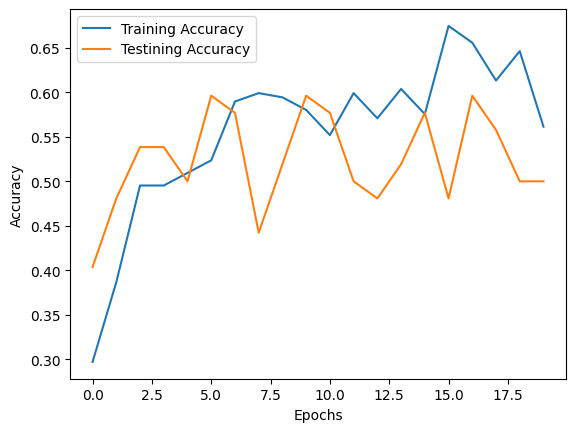

In [156]:
plt.plot(history_vgg19.history['accuracy'],label='Training Accuracy')
plt.plot(history_vgg19.history['val_accuracy'],label='Testining Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

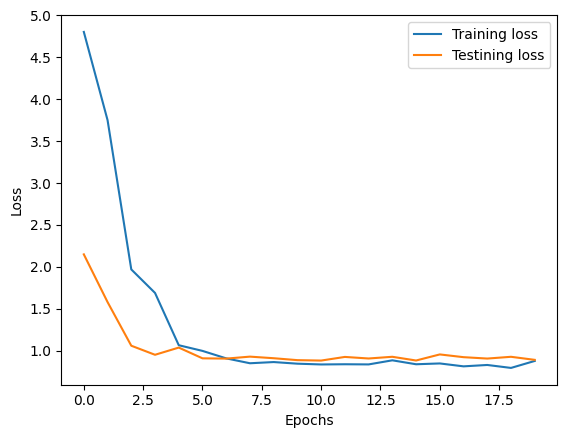

In [157]:
plt.plot(history_vgg19.history['loss'],label='Training loss')
plt.plot(history_vgg19.history['val_loss'],label='Testining loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [163]:
threshold=0.5
# Get true labels for validation data
val_true_labels4 = val_generator.classes
# Get predictions from the model
y_pred_xcp4 = model_vgg19.predict(val_generator)

# Convert predicted probabilities to class labels
y_pred_labels4 = np.argmax(y_pred_xcp2, axis=1)
# Calculate accuracy
accuracy4 = accuracy_score(val_true_labels4, y_pred_labels4)
print("Validation Accuracy: {:.2f}%".format(accuracy4 * 100))

2/2 [==============================] - 2s 846ms/step
Validation Accuracy: 63.46%


In [160]:
sample_img = img_to_array(img)

# Resize the image to match the model's input shape (224, 224)
sample_img = cv.resize(sample_img, (224, 224))

# Normalize the pixel values to the range [0, 1]
sample_img = sample_img.astype(np.float32) / 255.0

# Reshape the image to a single-sample batch with the appropriate shape
sample_img = np.expand_dims(sample_img, axis=0)

# Now you can use the model to predict on the sample_img
predictions4 = model_vgg19.predict(sample_img)
predictions4

print("Predictions:", predictions4)

1/1 [==============================] - 0s 353ms/step
Predictions: [[0.38739643 0.34070167 0.27190194]]


In [161]:
s={'Angery':predictions4[0][0]*100,
   'Happy':predictions4[0][1]*100,
   'Sad':predictions4[0][2]*100}
pd.DataFrame([s],index=['Unknow boy'])

,Angery,Happy,Sad
Unknow boy,38.739643,34.070167,27.190194


In [167]:
d={"Model Name":['Model-1','Model-2','Model-3','Model4','Model-5'],
    "Score":[accuracy_score(val_true_labels, y_pred_labels),accuracy_score(val_true_labels1, y_pred_labels1),accuracy_score(val_true_labels2, y_pred_labels2),accuracy_score(val_true_labels3, y_pred_labels3),accuracy_score(val_true_labels4, y_pred_labels4)]}
d

{'Model Name': ['Model-1', 'Model-2', 'Model-3', 'Model4', 'Model-5'],
 'Score': [0.6153846153846154,
  0.6923076923076923,
  0.6346153846153846,
  0.6346153846153846,
  0.6346153846153846]}

In [168]:
pd.DataFrame(d)

,Model Name,Score
0,Model-1,0.615385
1,Model-2,0.692308
2,Model-3,0.634615
3,Model4,0.634615
4,Model-5,0.634615


In [171]:
print("Now as we see that our model is model-2!!")

Now as we see that our model is model-2!!
